<a href="https://colab.research.google.com/github/rjy1022/my_assets/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This notebook contains modified excerpts from the [Hands-One Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurelien Geron; the content is available [on GitHub](https://github.com/ageron/handson-ml2). The code is released under the [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).  In addition, aspects have been adapted from the Neuromatch course materials [here](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md).*

To start, make sure that you go up to the **Runtime** menu, and make sure that *Hardware Accelerator* is set to *GPU* (otherwise your code will take forever to run)

In [ ]:
!nvidia-smi;
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers
from keras.layers import Dense, Input, Flatten, Reshape
from keras.layers import GaussianNoise, Dropout
from keras.models import Model, Sequential
from keras.utils import to_categorical
from umap import UMAP

Tue Nov 17 01:29:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# @title Helper Functions & Figure Settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(15):
    for k2 in range(15):
      k = k + 1
      plt.imshow(X[k],
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255,cmap='gray')
  plt.xlim((15 * 28, 0))
  plt.ylim((15 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 255])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")




def make_fashion_mnist_plot(X_valid_2D,X_valid,y_valid):
  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  cmap = plt.cm.tab10
  x = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
  plt.scatter(x[:, 0], x[:, 1], c=y_valid, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(x):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
  plt.axis("off")
  plt.show()

NameError: ignored

## Autoencoders and latent variables
How can simple algorithms capture relevant aspects of data and build robust models of the world?

Autoencoders are a family of artificial neural networks (ANNs) that learn internal representations through auxiliary tasks, i.e., *learning by doing*.

The primary task is to reconstruct output images based on a compressed representation of the inputs. This task teaches the network which details to throw away while still producing images that are similar to the inputs, as illustrated in the cartoon below.

&nbsp;

![MNIST cognitive task](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/mnist_task.png)

&nbsp;

The beauty of autoencoders is the possibility to see these internal representations. The bottleneck layer enforces data compression by having fewer units than input and output layers. Further limiting this layer to two or three units enables us to see how the autoencoder is organizing the data internally in two or three-dimensional **latent space** that provides a useful representation of our data. 

Mathematically, we can think of an autoencoder as two functions, an **encoder**, $f(\vec{x})$, that transforms the input data $\vec{x}$ into a low-dimensional representation, $\vec{z}$, and a **decoder**, $g(\vec{z})$, that takes the low-dimensional generated from the encoder, and attempts to reconstruct $\vec{x}$.  In other words, the goal is to construct $f$ and $g$ such that $g(f(\vec{x})) \equiv \vec{x}' = \vec{x}$.  We think of $\vec{z}$ as our **code** (or **latent variable**), that is, a compressed representation of our input data.

###Building an autoencoder in Keras

To build an autoencoder, it is often useful to use the ```Sequential``` API in Keras.  Networks are built in a manner similarly to what we saw in the previous notebook, but it allows us to define the encoder and the decoder individually (and it helps us more easily keep track of the layer dependencies as we create deeper networks).  

For instance, let's say that we want to take a bunch of 28$\times$28 pixel images (like MNIST), and create a stacked autoencoder where the first later of the encoder has 100 neurons and the middle layer has 30 neurons (the decoder is just the mirror of this).  We can define the autoencoder model via:

In [ ]:
#define the encoder (flatten the image, then a 100 neuron layer, then a 30 neuron layer)
stacked_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
])

#define the decoder (a 100 neuron layer that takes an input of size 30, followed by a )
stacked_decoder = Sequential([
    Dense(100, activation="selu", input_shape=[30]),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])

#create the model
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

#compile the model (using crossentropy as the loss function and the 'adam' optimizer)
stacked_ae.compile(loss="binary_crossentropy",optimizer='adam', metrics=['accuracy'])

Note how we are using the SELU (Scaled Expoential Linear Unit) here instead of ReLUs, tanh, etc.  This function is given by:
\begin{equation}
\phi(x) = \left\{
        \begin{array}{ll}
            -\lambda x & \quad x \leq 0 \\
            \lambda\alpha(e^x-1) & \quad x \geq 0
        \end{array}
    \right.
\end{equation}
where $\alpha$ = 1.67326324 and $\lambda$ = 1.05070098 (it's complicated...).  It turns out that this function has much better properties than ReLUs, since it has a gradient everywhere (including below zero). 

###An example: the Fashion MNIST Dataset

As discussed in class, the Fashion MNIST data set is a collection of 28$\times$28 pixel images of clothing, shoes, and other fashion-related objects.  For variety (there are only so many hand-written digits that one can look at), we will load this data set and will apply an autoencoder to these data.

4423680/4422102 [==============================] - 0s 0us/step


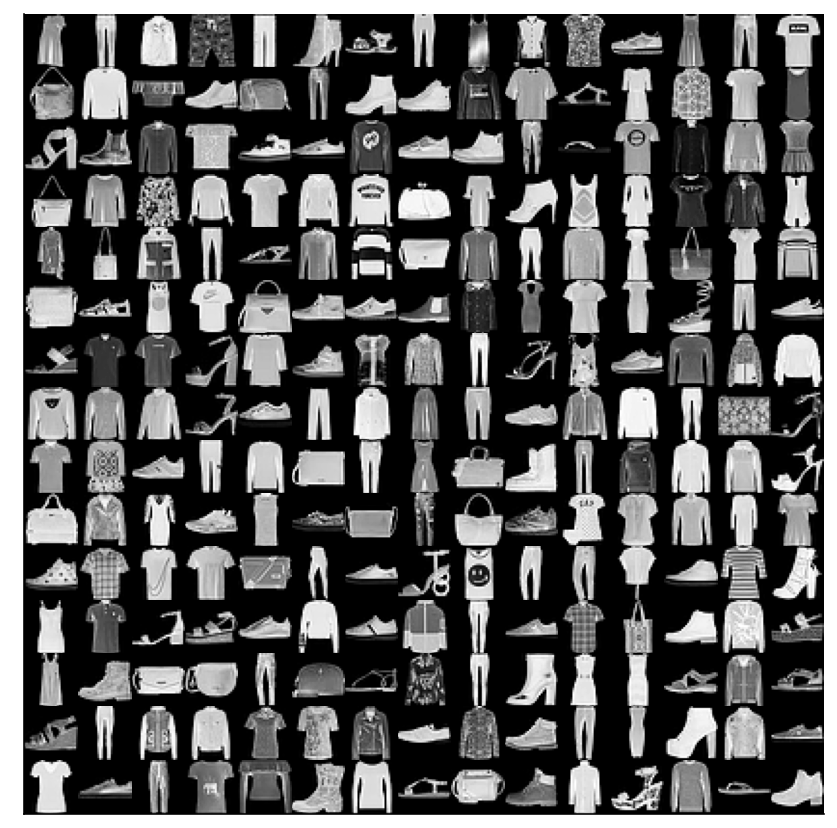

Training Set Shape = (55000, 28, 28)

Validation Set Shape = (5000, 28, 28)

Test Set Shape = (10000, 28, 28)



In [ ]:
#Load the Fashion MNIST Data, plot example images, and break into training, test, and validation sets

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data();
plot_MNIST_sample(X_train_full)
X_train_full = X_train_full.astype(np.float32) / 255; #this is to put all of the images between 0 & 1, which is often helpful
X_test = X_test.astype(np.float32) / 255;
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:];
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:];

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')
print('Test Set Shape = '+str(np.shape(X_test))+'\n')

Given the MNIST images that we have imported and the ```stacked_ae``` model defined in the previous section, we can now fit an autoencoder to these data (here using a batch size of 200 and training for 20 epochs).

In [ ]:
#train the model for 20 epochs.  Note that we are trying to fit X_train to itself, using X_valid as the validation data
history = stacked_ae.fit(X_train, X_train, batch_size=200,epochs=20,validation_data=(X_valid, X_valid))

Epoch 1/20
275/275 [==============================] - 1s 4ms/step - loss: 0.3509 - accuracy: 0.0804 - val_loss: 0.3092 - val_accuracy: 0.0987
Epoch 2/20
275/275 [==============================] - 1s 3ms/step - loss: 0.3012 - accuracy: 0.1076 - val_loss: 0.2987 - val_accuracy: 0.1137
Epoch 3/20
275/275 [==============================] - 1s 3ms/step - loss: 0.2940 - accuracy: 0.1204 - val_loss: 0.2938 - val_accuracy: 0.1226
Epoch 4/20
275/275 [==============================] - 1s 3ms/step - loss: 0.2904 - accuracy: 0.1274 - val_loss: 0.2910 - val_accuracy: 0.1327
Epoch 5/20
275/275 [==============================] - 1s 3ms/step - loss: 0.2881 - accuracy: 0.1327 - val_loss: 0.2889 - val_accuracy: 0.1378
Epoch 6/20
275/275 [==============================] - 1s 3ms/step - loss: 0.2864 - accuracy: 0.1366 - val_loss: 0.2876 - val_accuracy: 0.1399
Epoch 7/20
275/275 [==============================] - 1s 3ms/step - loss: 0.2851 - accuracy: 0.1402 - val_loss: 0.2865 - val_accuracy: 0.1432
Epoch 

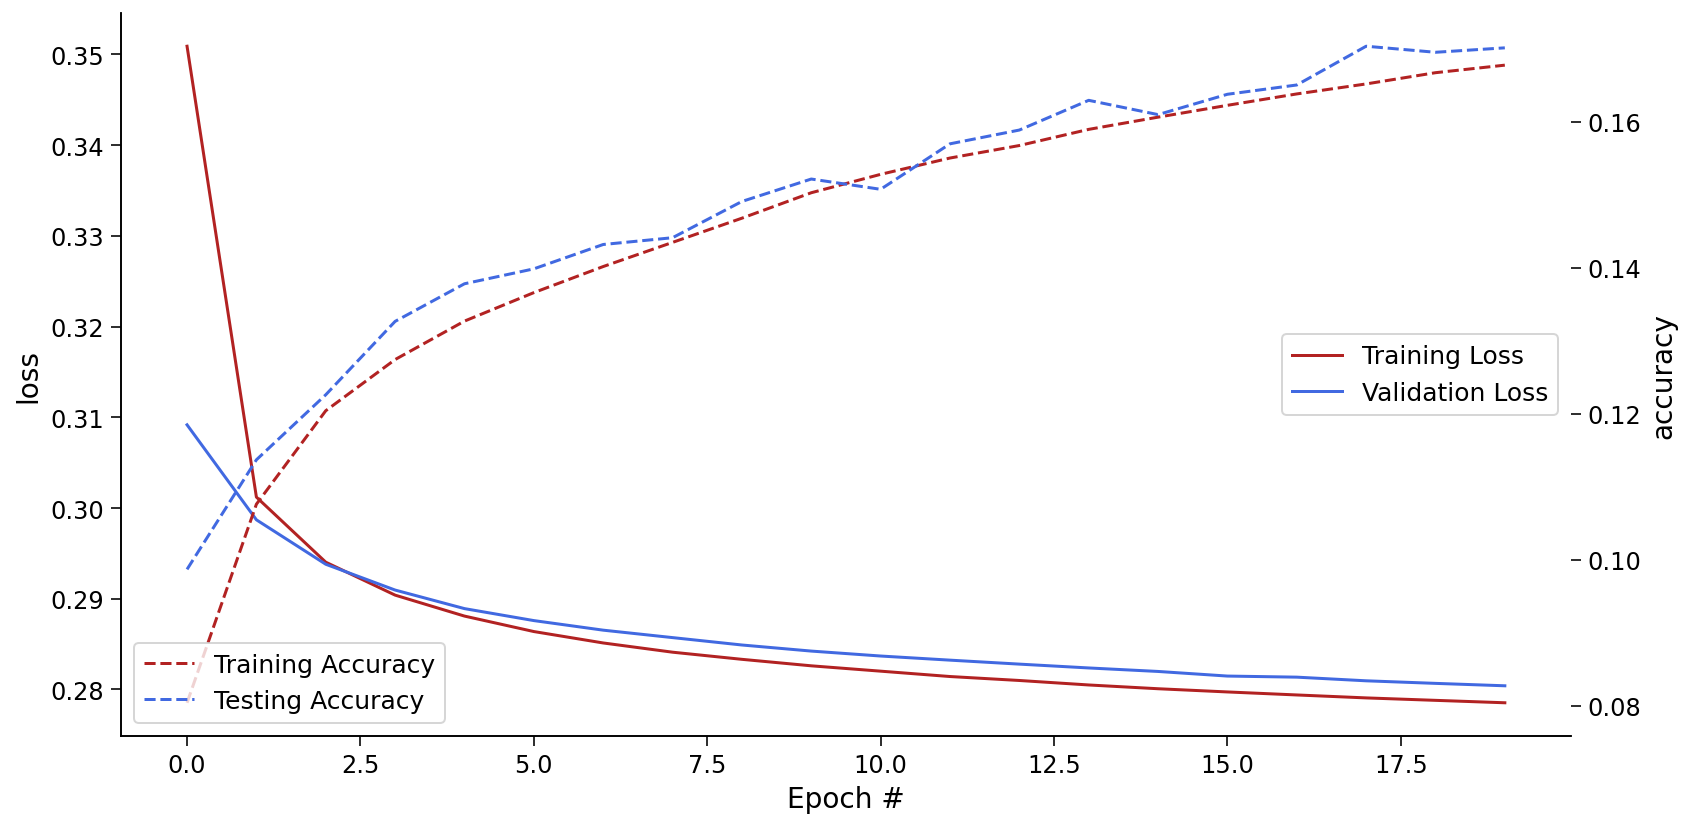

In [ ]:
#plot loss & accuracy
plot_training_history(history)

So how well did we do?  

Let's generate a few example reconstructions using the code below (original images on the top, reconstructed ones on the bottom):

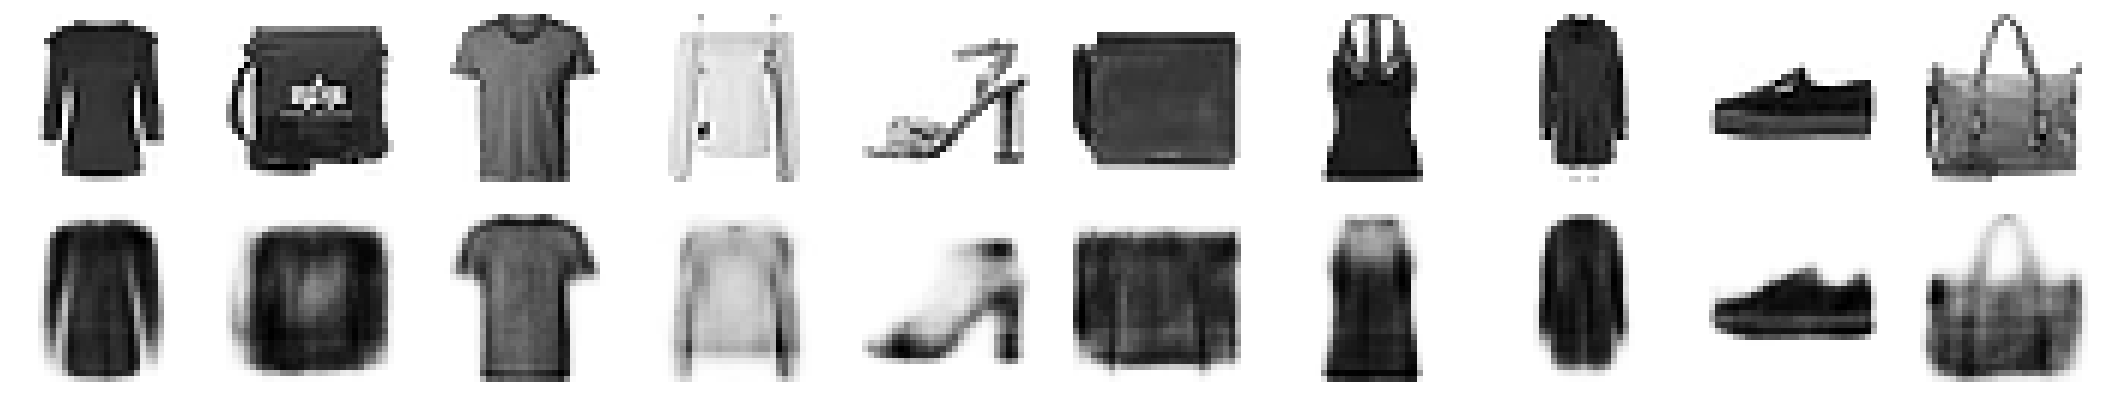

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

Not bad, considering that all of the 784 pixels were crammed into only 30 neurons in the middle layer!

So what is going on in this middle layer?  We can visualize this 30-dimensional space with UMAP.

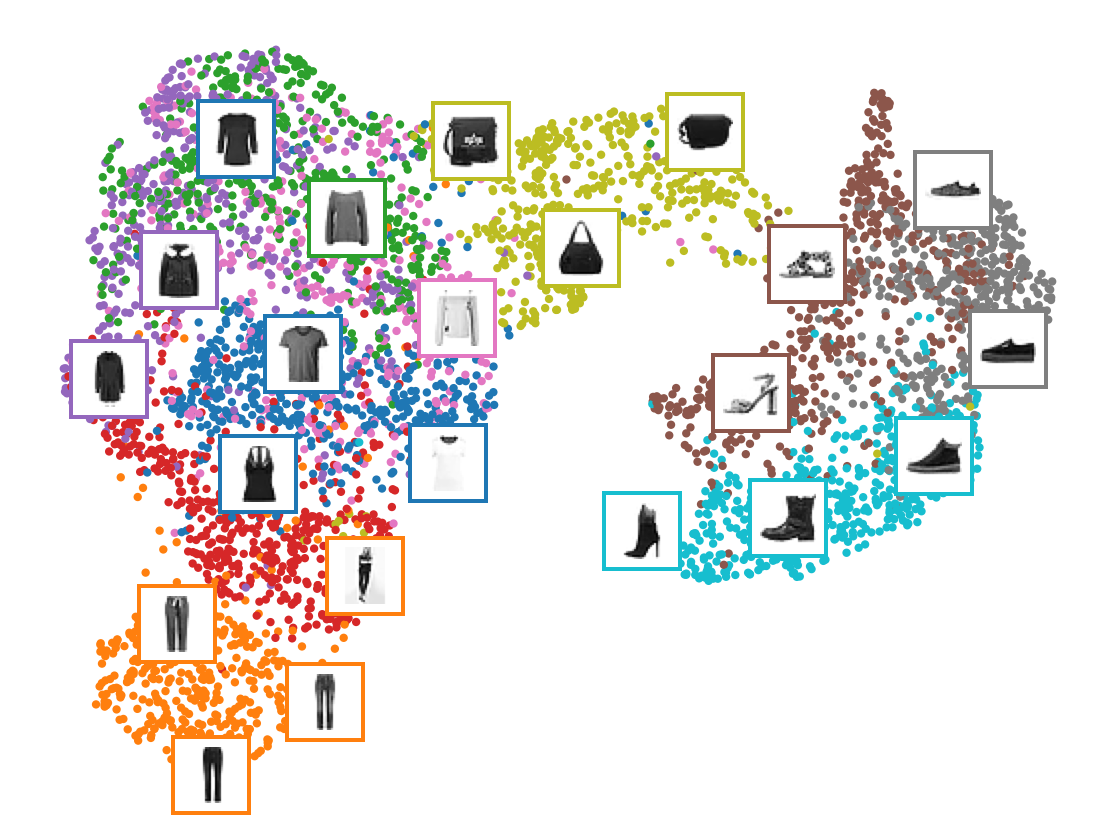

In [ ]:
#find the compressed representation (i.e., run the encoder forward without using the decoder)
X_valid_compressed = stacked_encoder.predict(X_valid)

#apply UMAP
ae_umap = UMAP(n_components=2,n_neighbors=15,min_dist=.5)
Y = ae_umap.fit_transform(X_valid_compressed)

#Make a pretty plot
make_fashion_mnist_plot(Y,X_valid,y_valid)

Here, the points are colored by their label (e.g., 'shoe' or 't-shirt' or 'purse'), and a few examples are shown.  Notice how the autoencoder found this structure!

<font color="blue"> **Question #1**: Apply UMAP to the raw validation data (```X_valid```) and plot using the ```make_fashion_mnist_plot()``` function above.  Describe the similarities (if any) and differences (if any) between the representations.  In this case, did we learn anything from training the autoencoder? </font>

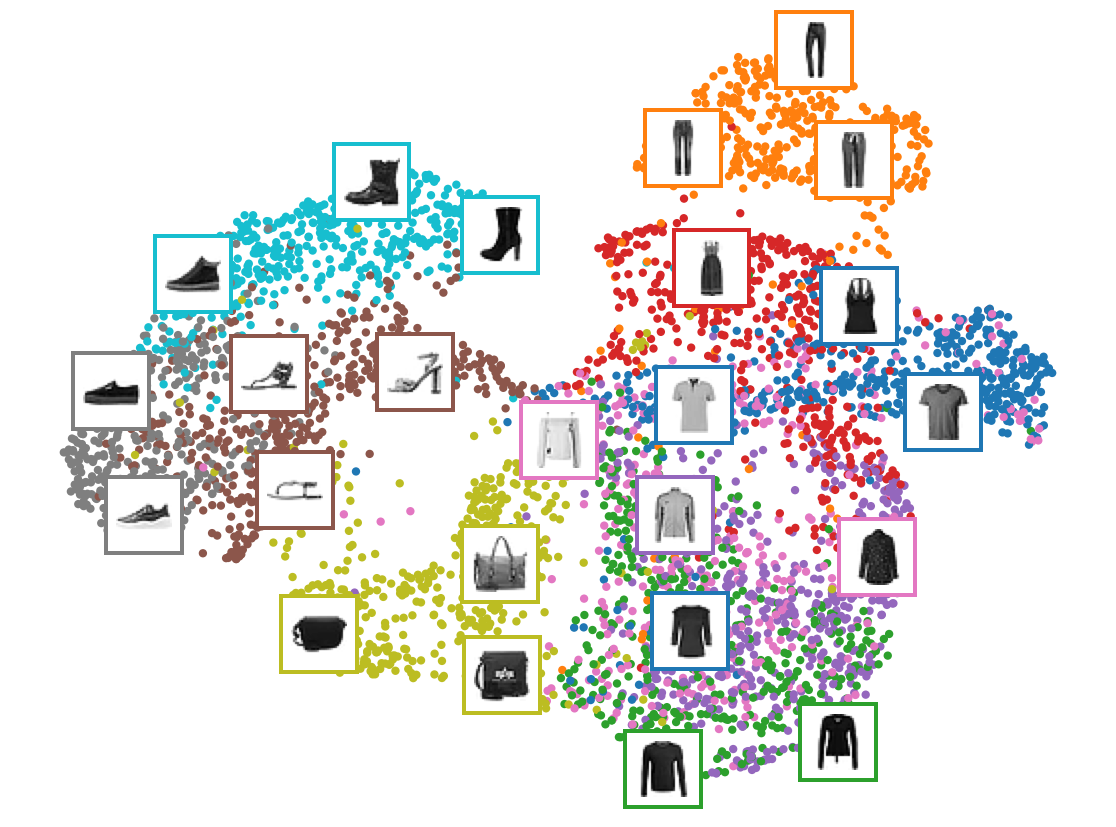

In [ ]:
#Type your code for Question #1 here
#apply UMAP
new_umap = UMAP(n_components=2,n_neighbors=15,min_dist=.5)
X_valid_flattened = []
for matrix in X_valid:
  X_valid_flattened.append(matrix.flatten())

Y = new_umap.fit_transform(X_valid_flattened)

#Make a pretty plot
make_fashion_mnist_plot(Y,X_valid,y_valid)

<font color=green> Describe the similarities (if any) and differences (if any) between the representations.  In this case, did we learn anything from training the autoencoder?

The representations look about the same. In this case, I don't believe we gained anything from training the encoder.</font>

<font color=blue> **Question #2**: Build a new stacked autoencoder, ```stacked_ae_small``` that is the same as ```stacked_ae```, but has one more layer in the encoder that has only 2 neurons (and an extra layer in the decoder to expand it as well).  In other words, it should be $784\to 100\to 30 \to 2 \to 30 \to 100 \to 784$.  Train this network on the same data as above.  Plot the validation and training test and lost using ```plot_training_history()```.  Is there a noticible difference in test loss/accuracy between the networks?  (Note: you might need to run it for 40-50 epochs in this case)</font>

Epoch 1/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2783 - accuracy: 0.1689 - val_loss: 0.2803 - val_accuracy: 0.1712
Epoch 2/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2781 - accuracy: 0.1701 - val_loss: 0.2800 - val_accuracy: 0.1739
Epoch 3/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2778 - accuracy: 0.1720 - val_loss: 0.2800 - val_accuracy: 0.1699
Epoch 4/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2777 - accuracy: 0.1726 - val_loss: 0.2796 - val_accuracy: 0.1764
Epoch 5/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.1735 - val_loss: 0.2796 - val_accuracy: 0.1703
Epoch 6/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2773 - accuracy: 0.1745 - val_loss: 0.2791 - val_accuracy: 0.1732
Epoch 7/40
275/275 [==============================] - 1s 3ms/step - loss: 0.2771 - accuracy: 0.1757 - val_loss: 0.2790 - val_accuracy: 0.1768
Epoch 

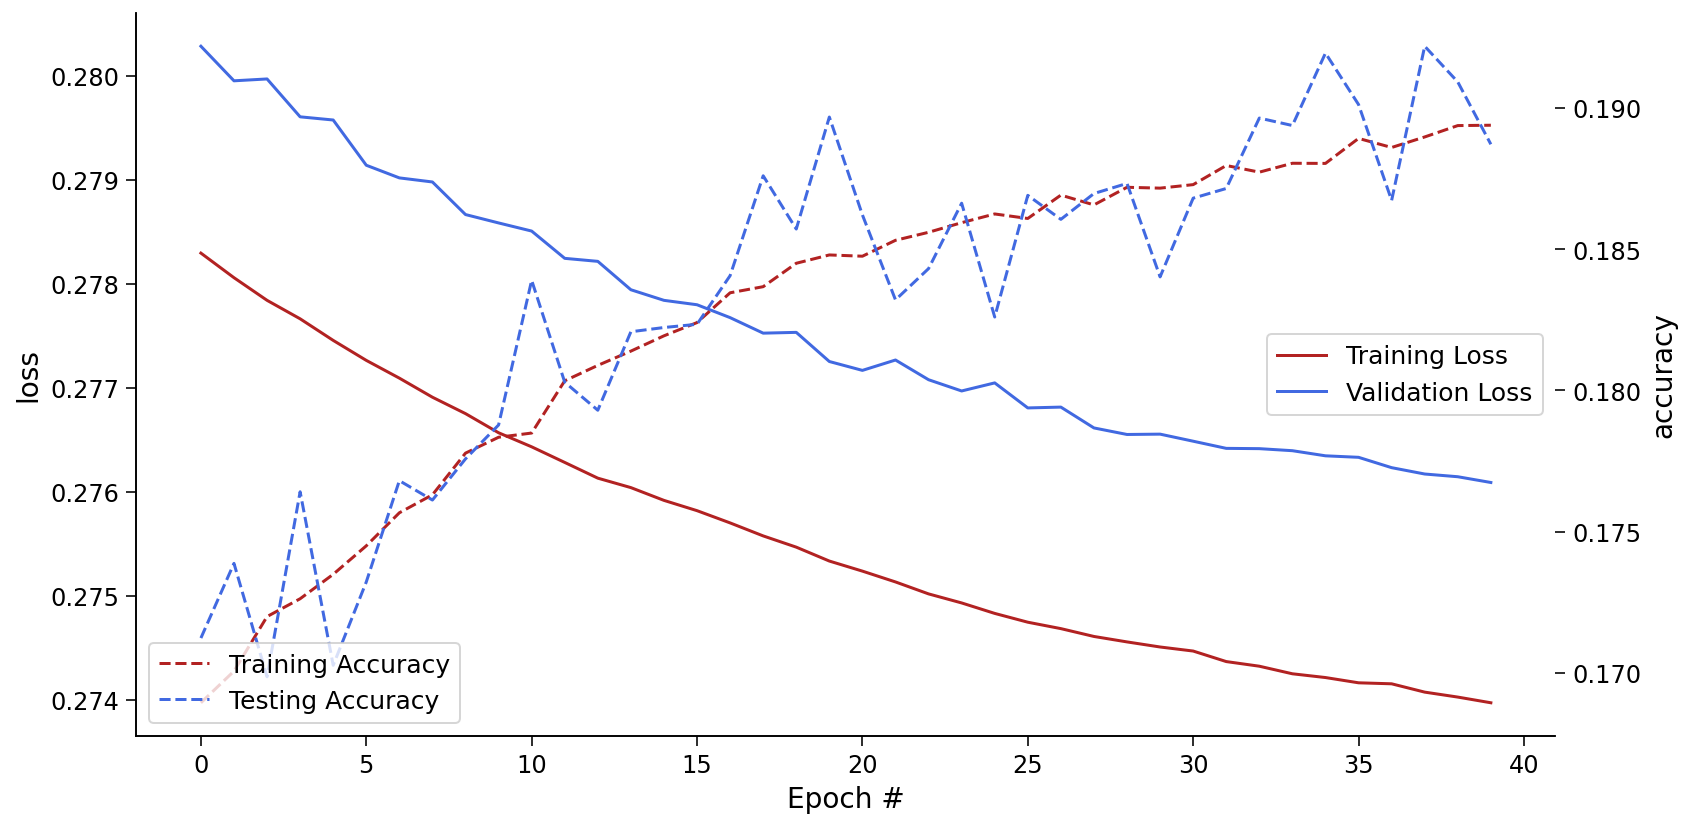

In [ ]:
#Type your code for Question #2 here
#define the encoder (flatten the image, then a 100 neuron layer, then a 30 neuron layer)
stacked_encoder = Sequential([
    Flatten(input_shape=[28,28]),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
    Dense(2, activation="selu")
])

#define the decoder (a 100 neuron layer that takes an input of size 30, followed by a )
stacked_decoder = Sequential([
    Dense(30, activation="selu", input_shape=[2]),                        
    Dense(100, activation="selu"),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])

#create the model
stacked_ae_small = Sequential([stacked_encoder, stacked_decoder])

#compile the model (using crossentropy as the loss function and the 'adam' optimizer)
stacked_ae_small.compile(loss="binary_crossentropy",optimizer='adam', metrics=['accuracy'])

#train the model for 20 epochs.  Note that we are trying to fit X_train to itself, using X_valid as the validation data
history_small = stacked_ae.fit(X_train, X_train, batch_size=200,epochs=40,validation_data=(X_valid, X_valid))

plot_training_history(history_small)


<font color=green> Is there a noticible difference in test loss/accuracy between the networks? 

No, there seems to be no difference. </font>

<font color=blue> **Question #3**: Use the ```show_reconstructions()``` function (see above) to display a few example reconstructions from this new network.  Is the performance better, worse, or about the same (by eye)?

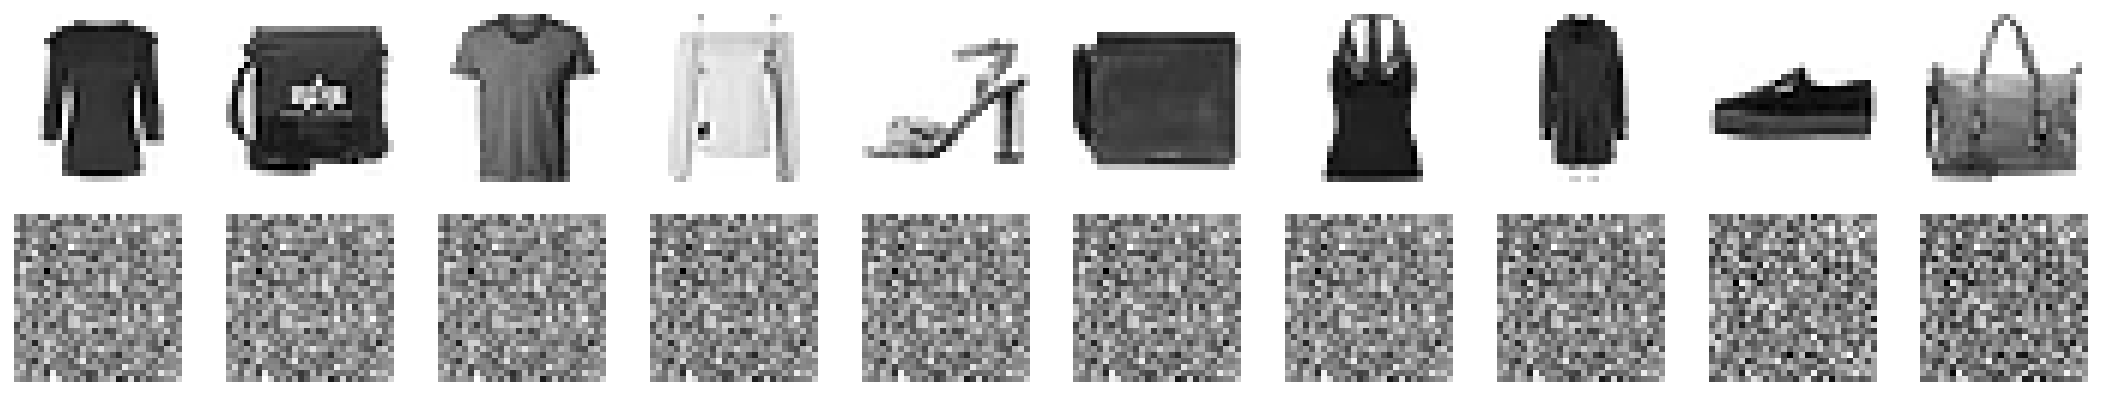

In [ ]:
#Type your code for Question #3 here
show_reconstructions(stacked_ae_small)

<font color=green>Is the performance better, worse, or about the same (by eye)? 

Worse.</font>

<font color=blue>**Question #4**: Use ```make_fashion_mnist_plot()``` to plot the 2d representation from the smallest layer of the network (no need for UMAP this time, since it's already 2-dimensional).  Is the structure different than the structure derived from the previous autoencoder?  If so, describe why this would be a better or worse (or equivalent) representation.</font>

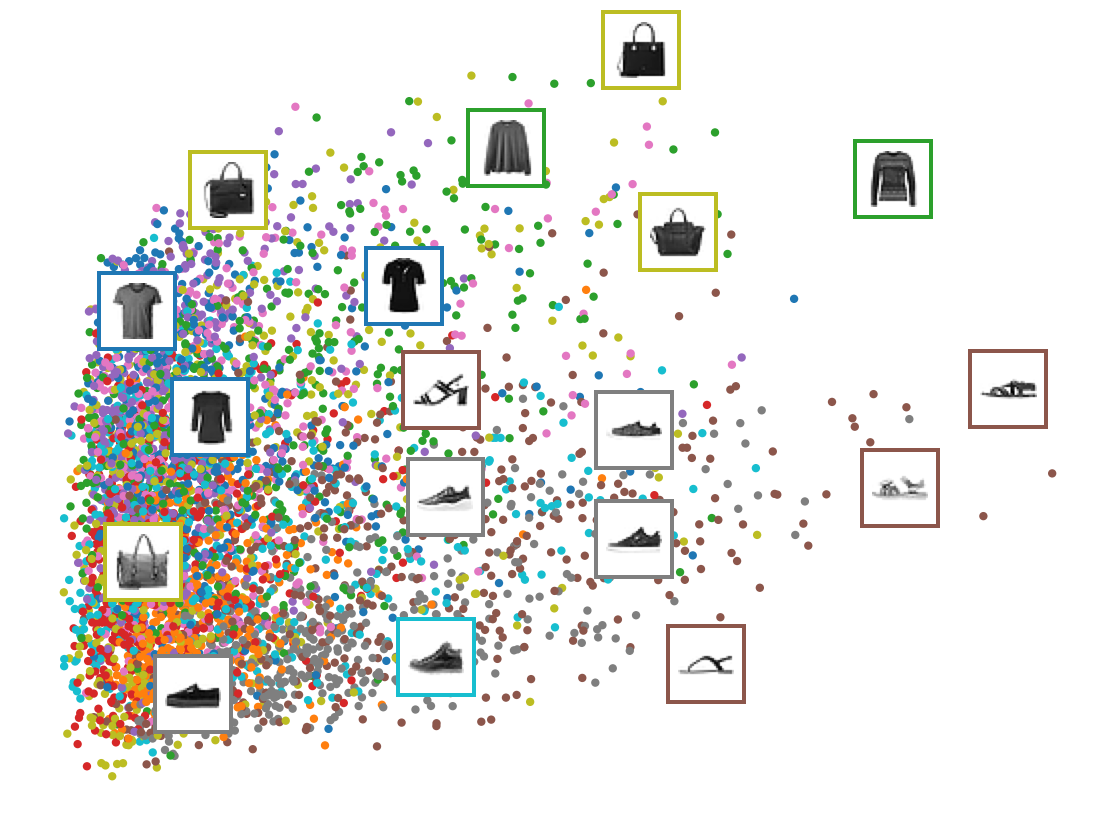

In [ ]:
#Type your code for Question #4 here
X_valid_compressed = stacked_encoder.predict(X_valid)

#Make a pretty plot
make_fashion_mnist_plot(X_valid_compressed,X_valid,y_valid)

<font color=green> Is the structure different than the structure derived from the previous autoencoder?  If so, describe why this would be a better or worse (or equivalent) representation.

It is much wore than the structure derived by the previous autoencoder. This would be because it is being compressed to 2 neurons.
</font>

###Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. This speeds up training (fewer parameters) and reduced the risk of overfitting.

For this, we need to use a custom layer in Keras, which we will call ```DenseTranspose```:

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

Thus, given this new layer type, we can define an autoencoder ($784\to 100\to  30 \to 100 \to 784$) with tied weights via:

In [ ]:
dense_1 = Dense(100, activation="selu")
dense_2 = Dense(30, activation="selu")

tied_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    Reshape([28, 28])
])

tied_ae = Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",optimizer='adam', metrics=['accuracy'])

<font color=blue>**Question #5**: Train ```tied_ae``` on the Fashion MNIST data for 10 epochs.  Compare the test accuracy and loss to the other two models that you've trained for 20 or more epochs. </font>

Epoch 1/10
275/275 [==============================] - 1s 3ms/step - loss: 0.3703 - accuracy: 0.0826 - val_loss: 0.3080 - val_accuracy: 0.1000
Epoch 2/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2996 - accuracy: 0.1084 - val_loss: 0.2964 - val_accuracy: 0.1167
Epoch 3/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2917 - accuracy: 0.1222 - val_loss: 0.2913 - val_accuracy: 0.1279
Epoch 4/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2879 - accuracy: 0.1313 - val_loss: 0.2884 - val_accuracy: 0.1352
Epoch 5/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2856 - accuracy: 0.1381 - val_loss: 0.2866 - val_accuracy: 0.1438
Epoch 6/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2840 - accuracy: 0.1441 - val_loss: 0.2851 - val_accuracy: 0.1494
Epoch 7/10
275/275 [==============================] - 1s 3ms/step - loss: 0.2828 - accuracy: 0.1492 - val_loss: 0.2840 - val_accuracy: 0.1509
Epoch 

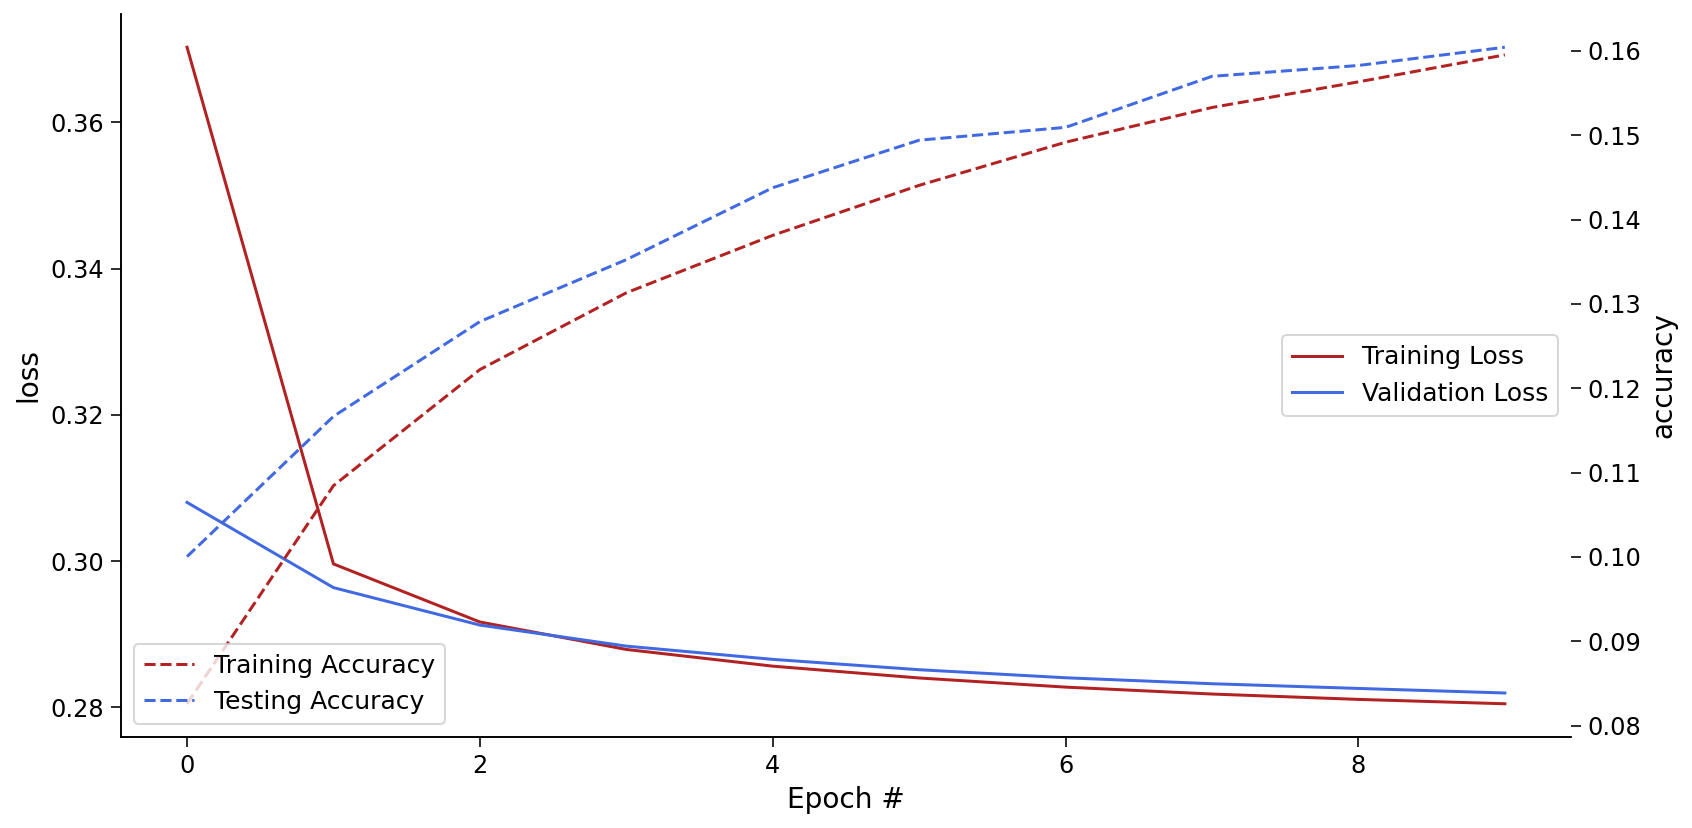

In [ ]:
#Type your code for Question #5 here
history_tied = tied_ae.fit(X_train, X_train, batch_size=200,epochs=10,validation_data=(X_valid, X_valid))

plot_training_history(history_tied)


<font color=green>Compare the test accuracy and loss to the other two models that you've trained for 20 or more epochs. 

The test accuracy and loss were about the same for 10 epochs. </font>

##Denoising autoencoders

A rather useful application of autoencoders is to remove noise from an image.  In other words, we will ask our encoder/decoder combination to return an image that can be less distorted than the one we started with!

The essential idea here is that we will use the autoencoder to find a low-dimensional description of the data that ignores aspects that we explicitly characterize as noise.  This noise could be Gaussian noise that we add to input data, or it could be that we purposefully delete parts of the data (e.g., set a pixel value to zero), so that the network doesn't overtrain on a particular part of the image.  This process is called **Dropout**.

If $X$ is our original data, $X'=g(f(X))$ is the autoencoder output, and $\tilde{X}$ is our noise-corrupted data.  This new autoencoder will try to solve the equation 
\begin{equation}
X = g(f(\tilde{X}))
\end{equation}
as accurately as possible (with minimal loss).

To create this network, we simply need to add an extra layer.  To add Gaussian noise, we can use ```GaussianNoise(sigma)``` (```sigma``` is the noise standard deviation), and to use Dropout, we can use ```Dropout(p)``` (```p``` is the probability of setting a given dimension/pixel to zero).

For the case of adding Gaussian noise with $\sigma = 0.2$, we use:

In [ ]:
denoising_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    GaussianNoise(0.2),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
    Dense(2, activation="selu")
])

denoising_decoder = Sequential([
    Dense(30, activation="selu", input_shape=[2]),                                         
    Dense(100, activation="selu"),                                         
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])


denoising_ae = Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="mse", optimizer='adam',metrics=['accuracy'])
history_denoising = denoising_ae.fit(X_train, X_train, epochs=20,batch_size=100, validation_data=(X_valid, X_valid))

Epoch 1/20
550/550 [==============================] - 2s 3ms/step - loss: 0.0649 - accuracy: 0.0490 - val_loss: 0.0580 - val_accuracy: 0.0512
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.0507 - accuracy: 0.0596 - val_loss: 0.0485 - val_accuracy: 0.0630
Epoch 3/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0430 - accuracy: 0.0714 - val_loss: 0.0382 - val_accuracy: 0.0771
Epoch 4/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0365 - accuracy: 0.0844 - val_loss: 0.0354 - val_accuracy: 0.0888
Epoch 5/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0337 - accuracy: 0.0878 - val_loss: 0.0326 - val_accuracy: 0.0908
Epoch 6/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.0918 - val_loss: 0.0311 - val_accuracy: 0.0924
Epoch 7/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0307 - accuracy: 0.0942 - val_loss: 0.0305 - val_accuracy: 0.0913
Epoch 

**Note that for these types of networks, it is more common to get stuck in a bad initial condition, so if the loss/accuracy curves show little or no progress (see below), you should just run the code again.**

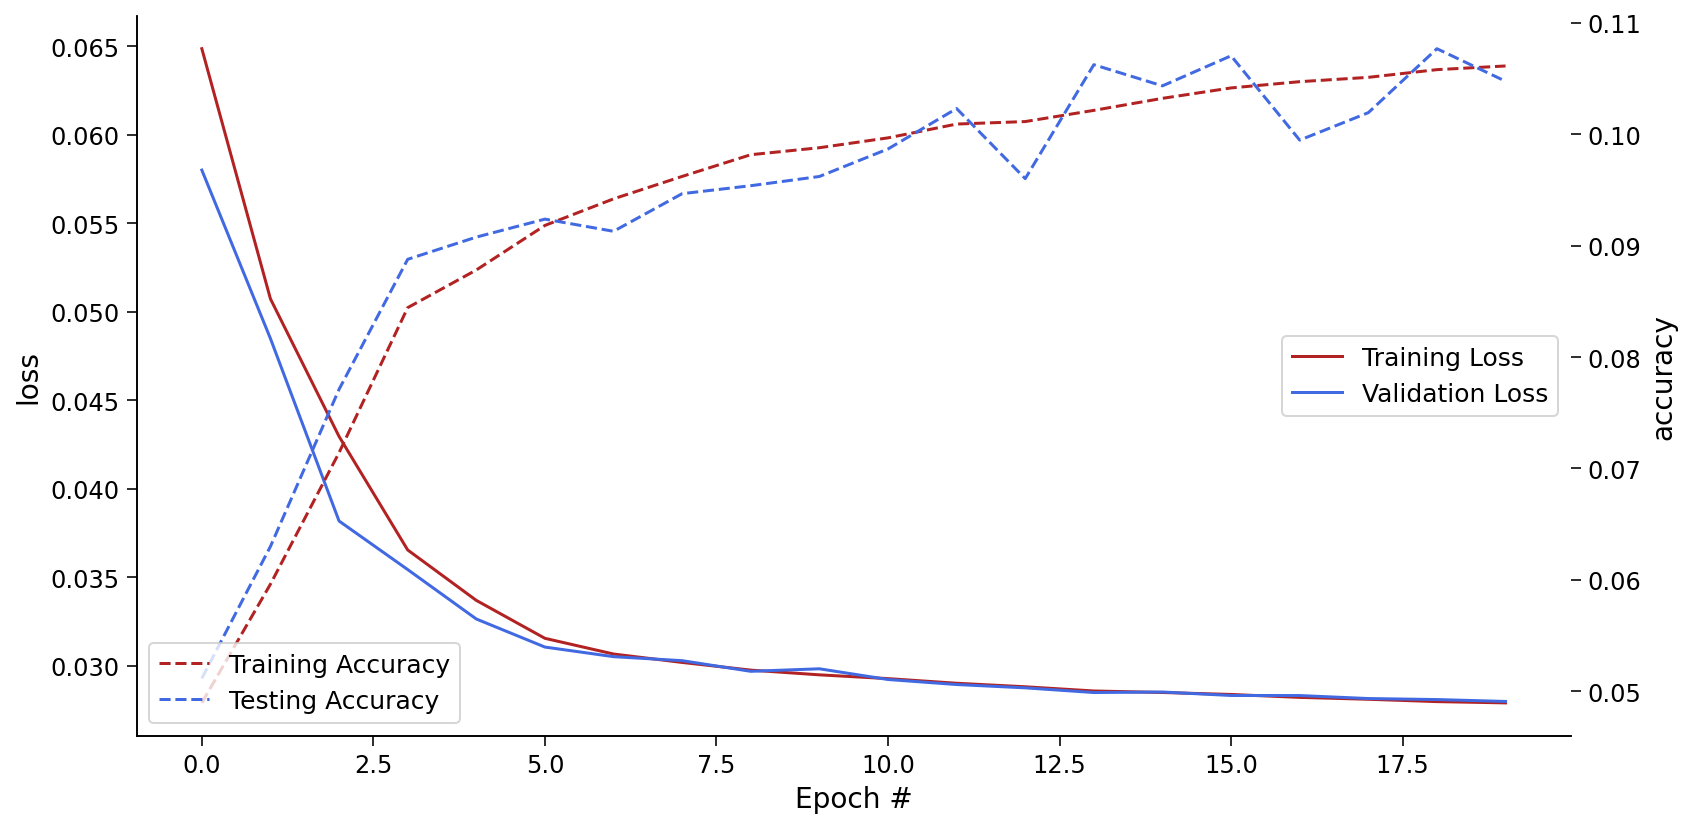

In [ ]:
plot_training_history(history_denoising)

Now let's see how it did!  We will input some noise to the images, and we'll see if the network was able to eliminate it.

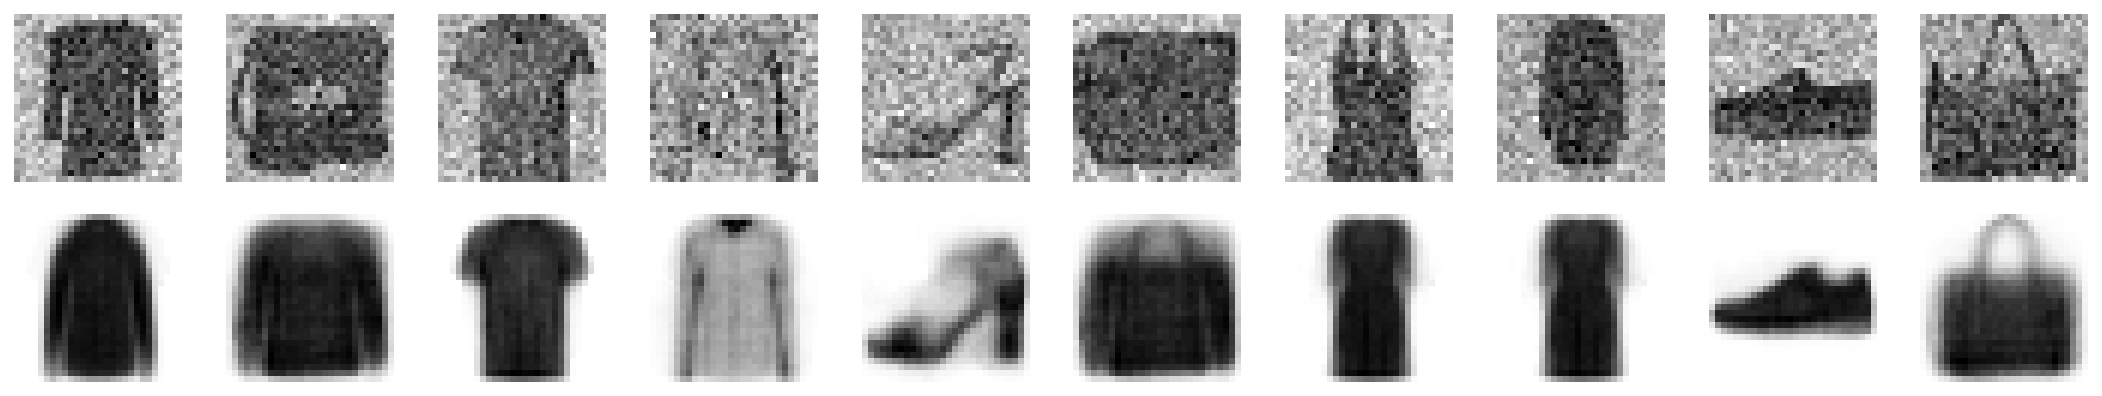

In [ ]:
noise = GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

Not bad!  While the images are fuzzy (they've lost some definition), the gaussian pixel blur is gone.

<font color=blue> **Question #6**: Use the function above, but now with $\sigma =3$.  Compare the outputs to the those above.  Describe why you think that you are you seeing this effect? (It might be helpful to use ```make_fashion_mnist_plot()``` on the post-encoder values for the non-noisy data set)

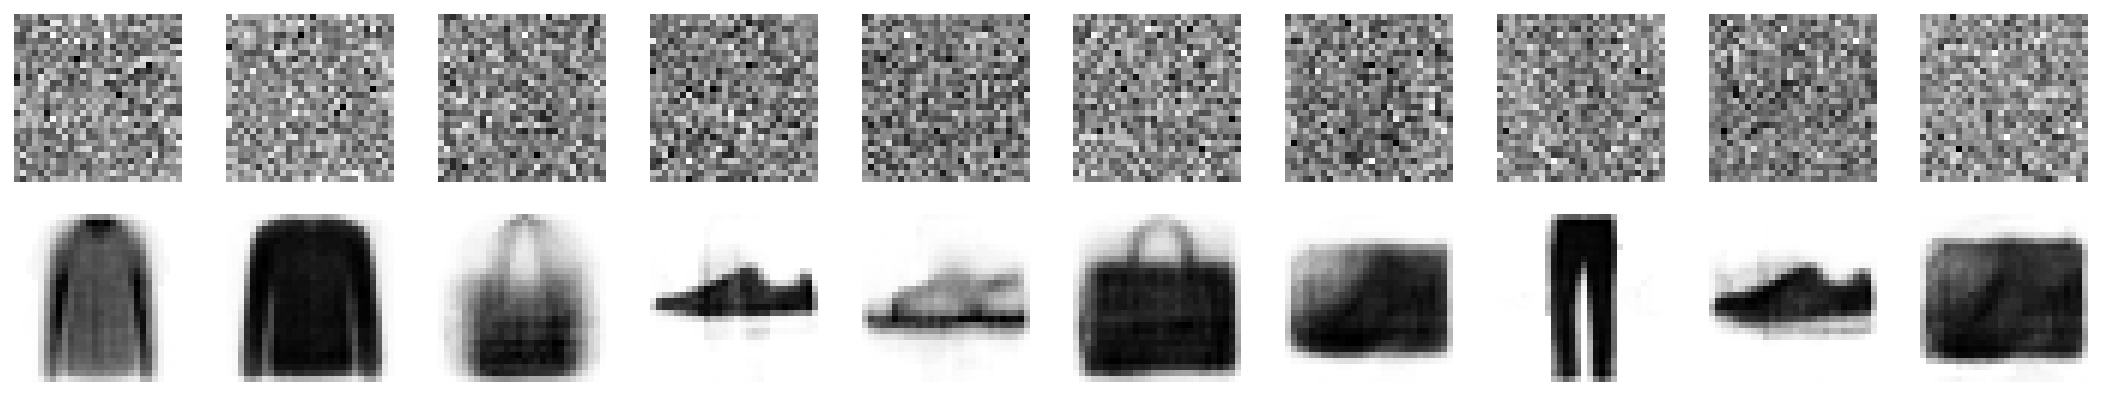

In [ ]:
#Type your code for Question #6 here
noise = GaussianNoise(3)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

<font color=green> Compare the outputs to the those above.  Describe why you think that you are you seeing this effect?

The noise is higher so our autoencoder reconstructs the image worse.

<font color=blue> **Question #7**: Train a similar network, but now using Dropout (use ```p``` = 0.5).  You should call the network ```dropout_ae```.  Remember to test the loss and accuracy curves to make sure that the network is actually training (and re-run if necessary).

Epoch 1/20
550/550 [==============================] - 2s 3ms/step - loss: 0.0765 - accuracy: 0.0486 - val_loss: 0.0558 - val_accuracy: 0.0590
Epoch 2/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0496 - accuracy: 0.0615 - val_loss: 0.0481 - val_accuracy: 0.0590
Epoch 3/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0466 - accuracy: 0.0662 - val_loss: 0.0463 - val_accuracy: 0.0648
Epoch 4/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0456 - accuracy: 0.0698 - val_loss: 0.0458 - val_accuracy: 0.0724
Epoch 5/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0447 - accuracy: 0.0722 - val_loss: 0.0445 - val_accuracy: 0.0733
Epoch 6/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0441 - accuracy: 0.0751 - val_loss: 0.0447 - val_accuracy: 0.0828
Epoch 7/20
550/550 [==============================] - 1s 3ms/step - loss: 0.0435 - accuracy: 0.0776 - val_loss: 0.0435 - val_accuracy: 0.0776
Epoch 

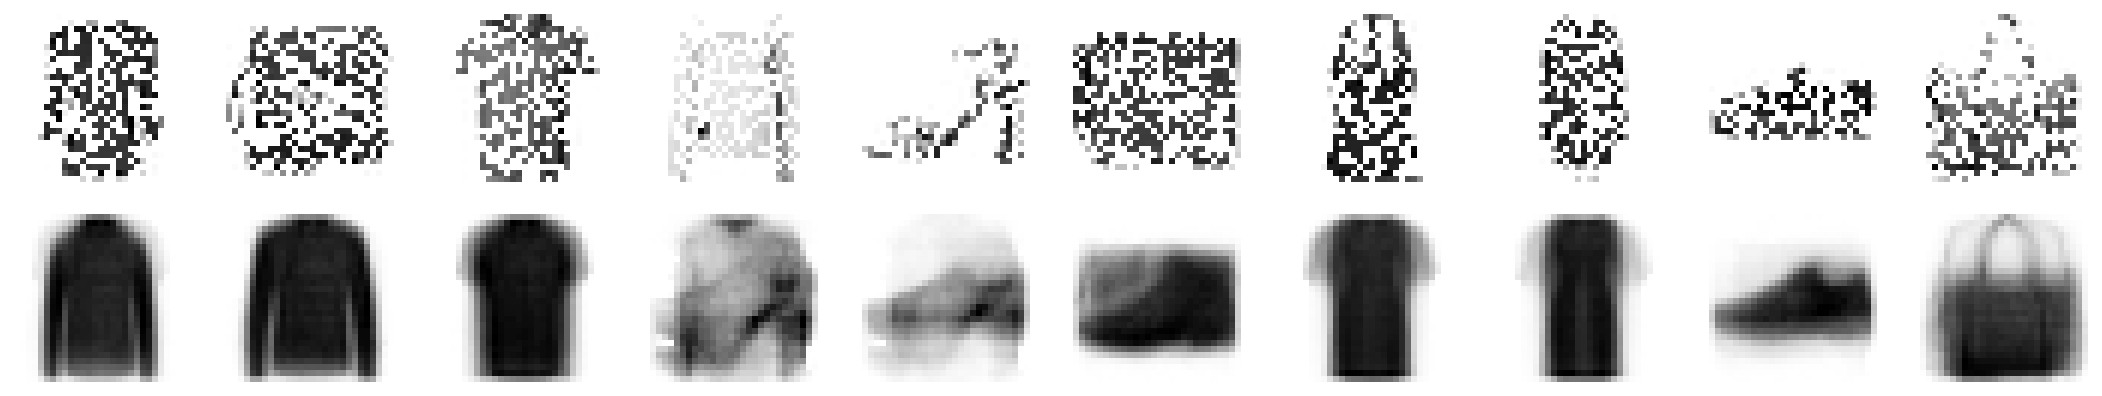

In [ ]:
#Type your code for Question #7 here

noise = Dropout(0.5)
dropout_encoder = Sequential([
    Flatten(input_shape=[28, 28]),
    GaussianNoise(0.2),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
    Dense(2, activation="selu")
])

dropout_decoder = Sequential([
    Dense(30, activation="selu", input_shape=[2]),                                         
    Dense(100, activation="selu"),                                         
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])


dropout_ae = Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="mse", optimizer='adam',metrics=['accuracy'])
history_dropout = dropout_ae.fit(X_train, X_train, epochs=20,batch_size=100, validation_data=(X_valid, X_valid))
show_reconstructions(dropout_ae, noise(X_valid, training=True))

<font color=blue>**Question #8**: You can use: </font>

<font color=blue> ```dropout = Dropout(p)``` </font>

<font color=blue> ```show_reconstructions(dropout_ae, dropout(X_valid, training=True))``` </font>

<font color=blue>to plot the examples of sending corrupted images through the autoencoder.  Plot these examples for various values of $p \in [0.5,1)$. At what point do the images reconstruction begin to appear inaccurate?  Is the network doing better than you can to $p\approx 0.9$?</font>


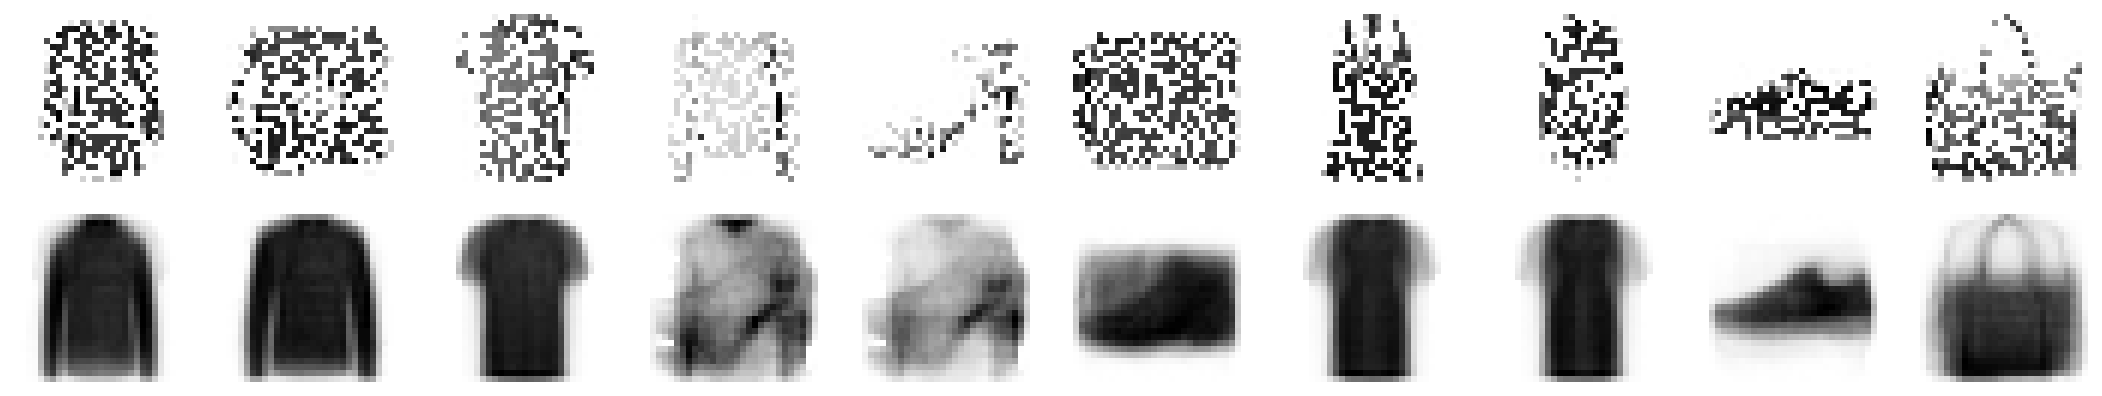

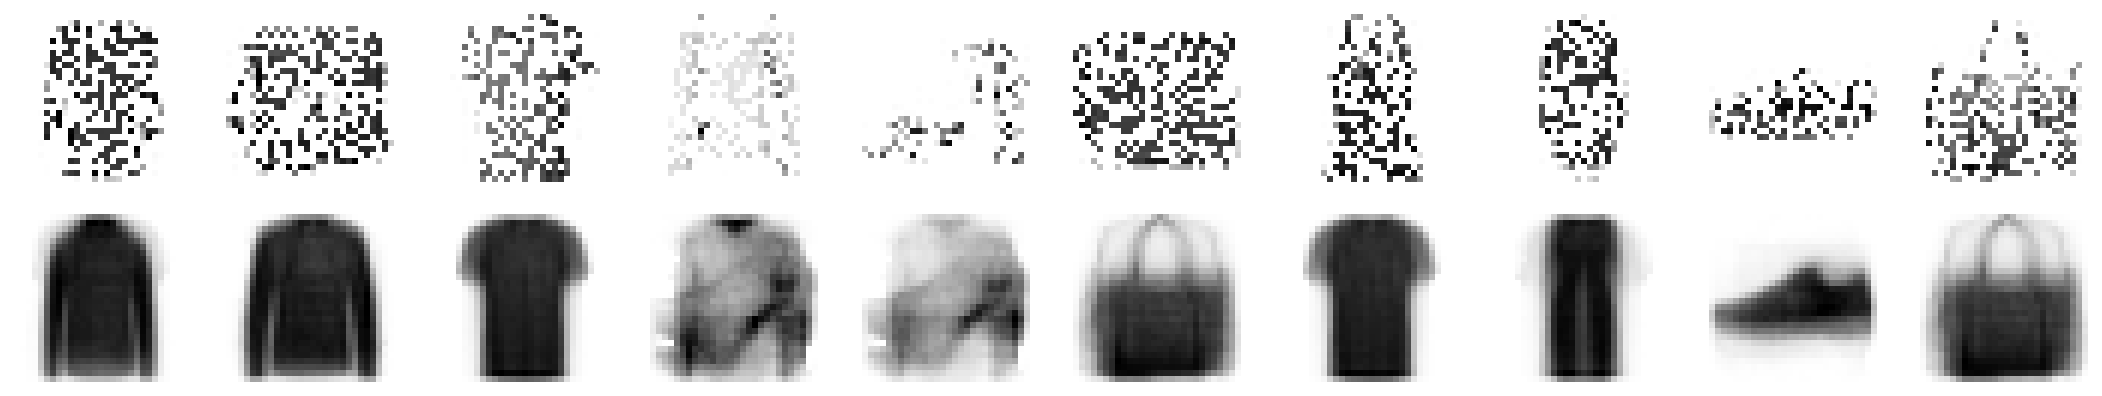

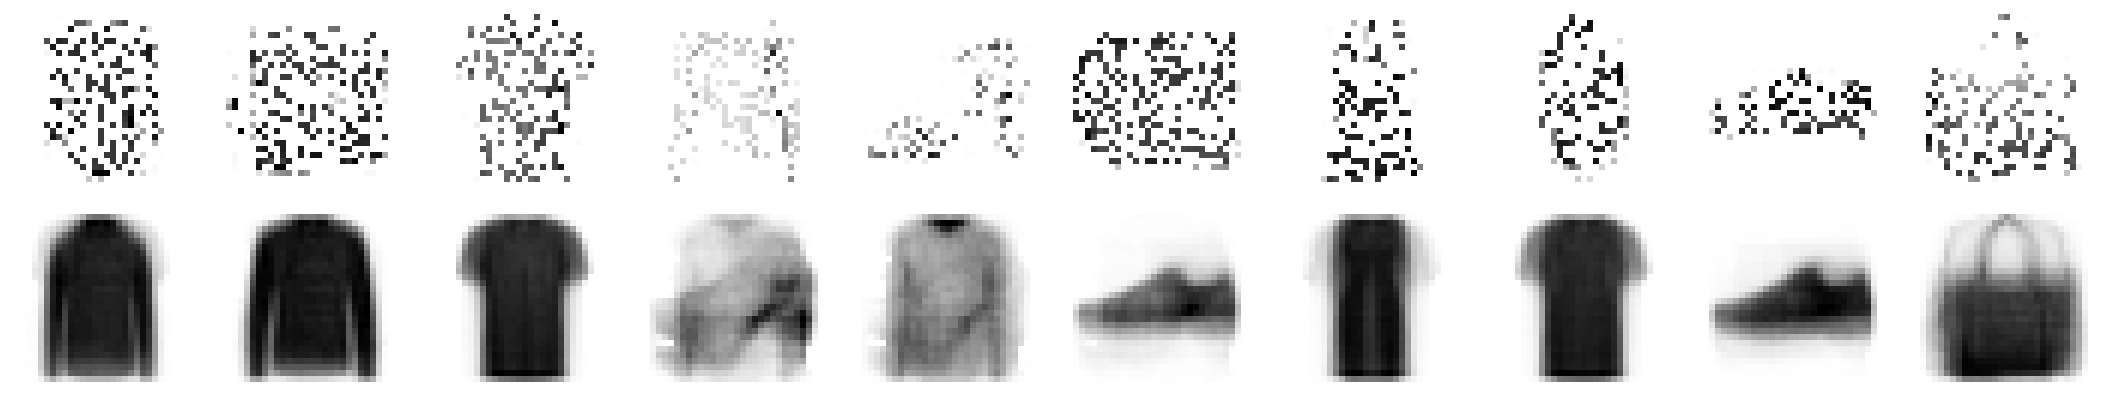

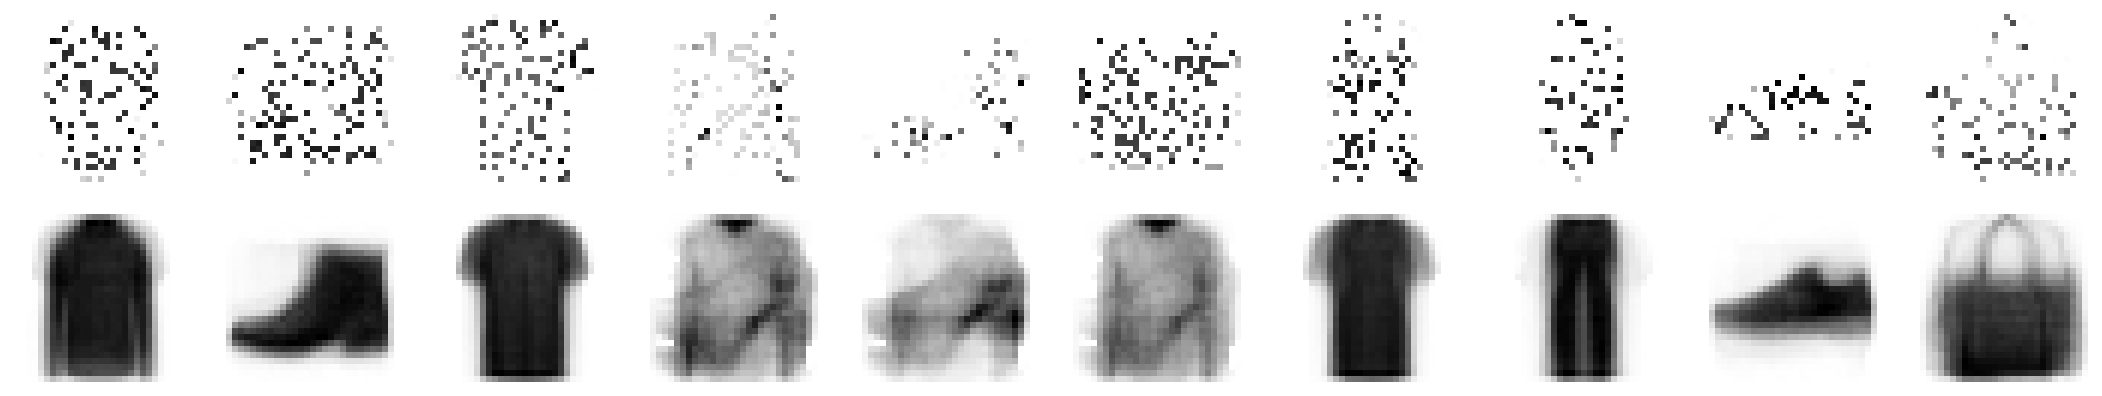

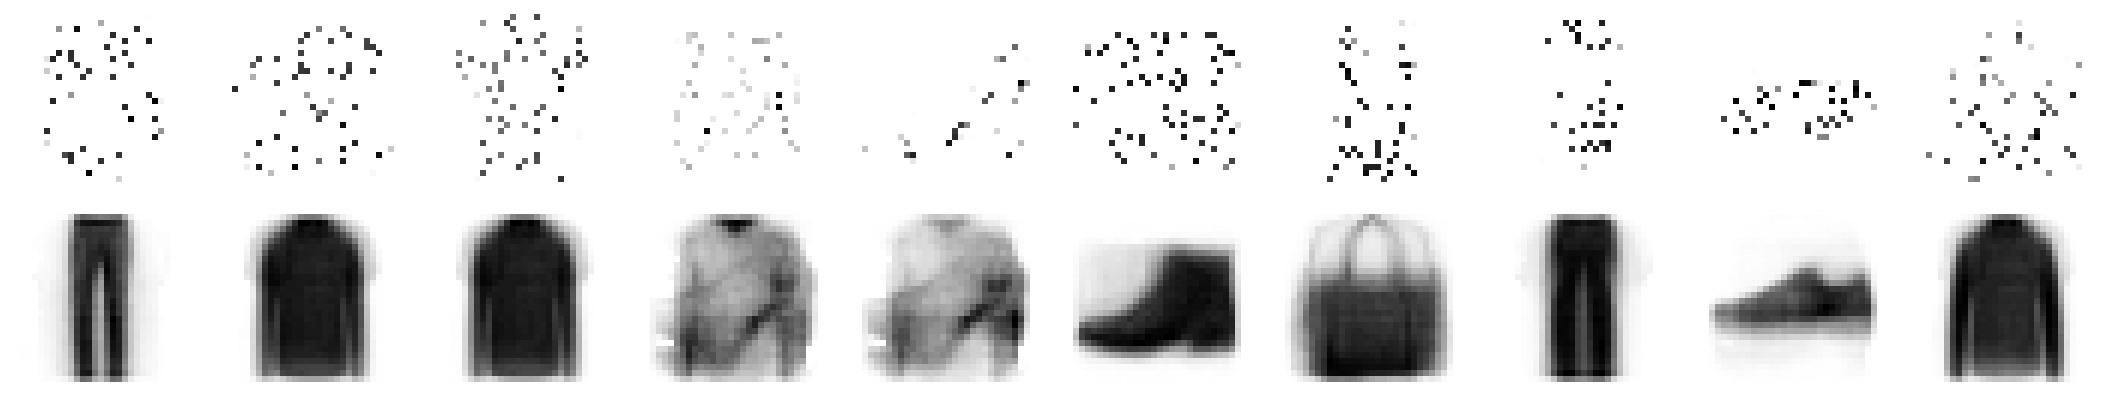

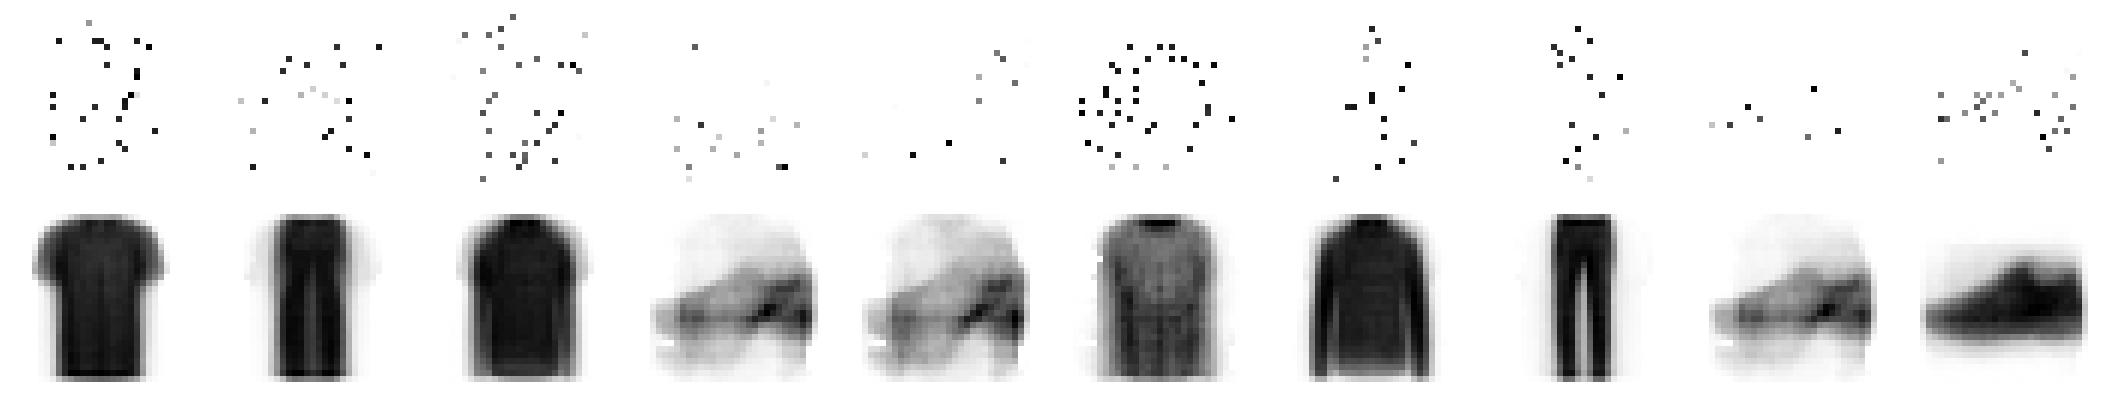

In [ ]:
#Type your code for Question #8 here
for x in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
  noise = Dropout(x)
  show_reconstructions(dropout_ae, noise(X_valid, training=True))

<font color=green> At what point do the images reconstruction begin to appear inaccurate?  Is the network doing better than you can to $p\approx 0.9$?

When we get to >.9, the image reconstruction begins to appear inaccurate. 

<font color="blue">**Question #9**: Apply ```make_fashion_mnist_plot()``` on the post-encoder values of the Dropout network.  Compare this plot to the plot you obtained from the non-denoising network in Question #4.  Explain why you think any differences might be occurring.</font>

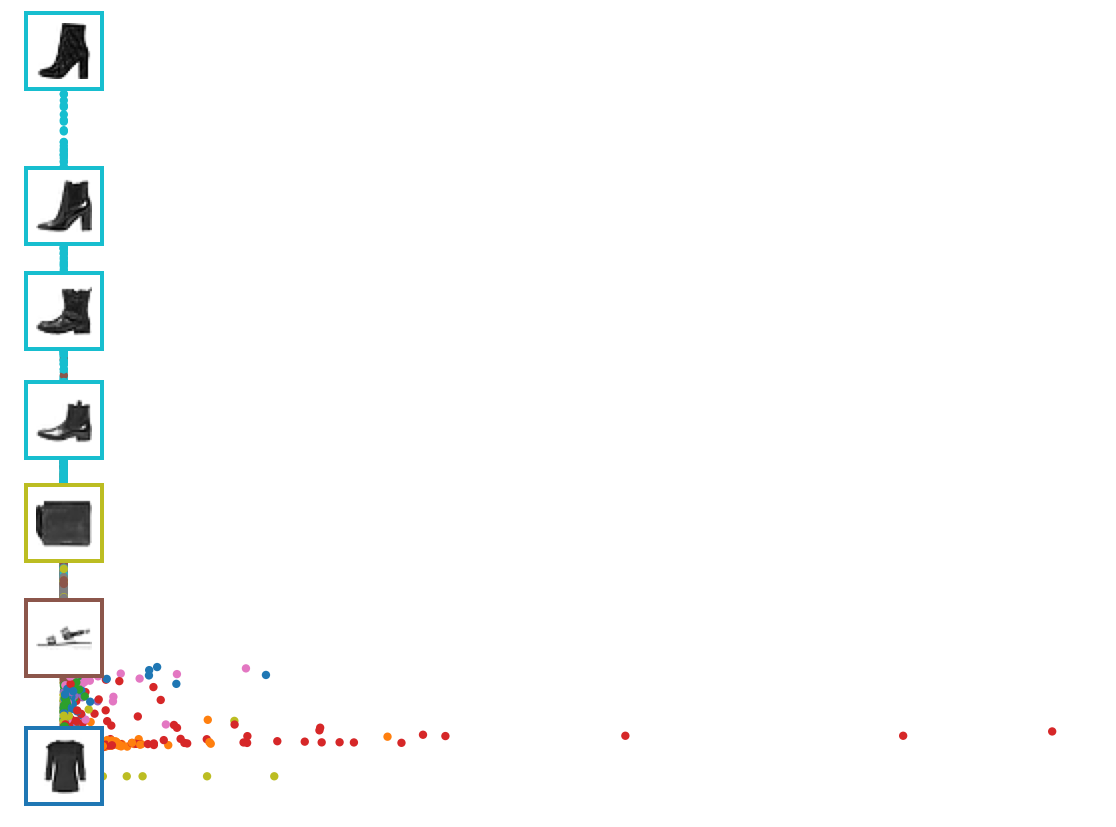

In [ ]:
#Type your code for Question #9 here
X_valid_compressed = dropout_encoder.predict(X_valid)

#Make a pretty plot
make_fashion_mnist_plot(X_valid_compressed,X_valid,y_valid)

<font color=green> Compare this plot to the plot you obtained from the non-denoising network in Question #4.  Explain why you think any differences might be occurring. 

We see better organization in this graph. Maybe the dropout forces it to learn more sparse representations of each object's features. </font>

<font color=blue> **Question #10**: Reconstruct images corrupted with Dropout ($p=0.8$) using the Gaussian noise autoencoder, and reconstruct images corrupted with Gaussian noise using the Dropout autoencoder ($\sigma=0.5$).  Describe what you see.

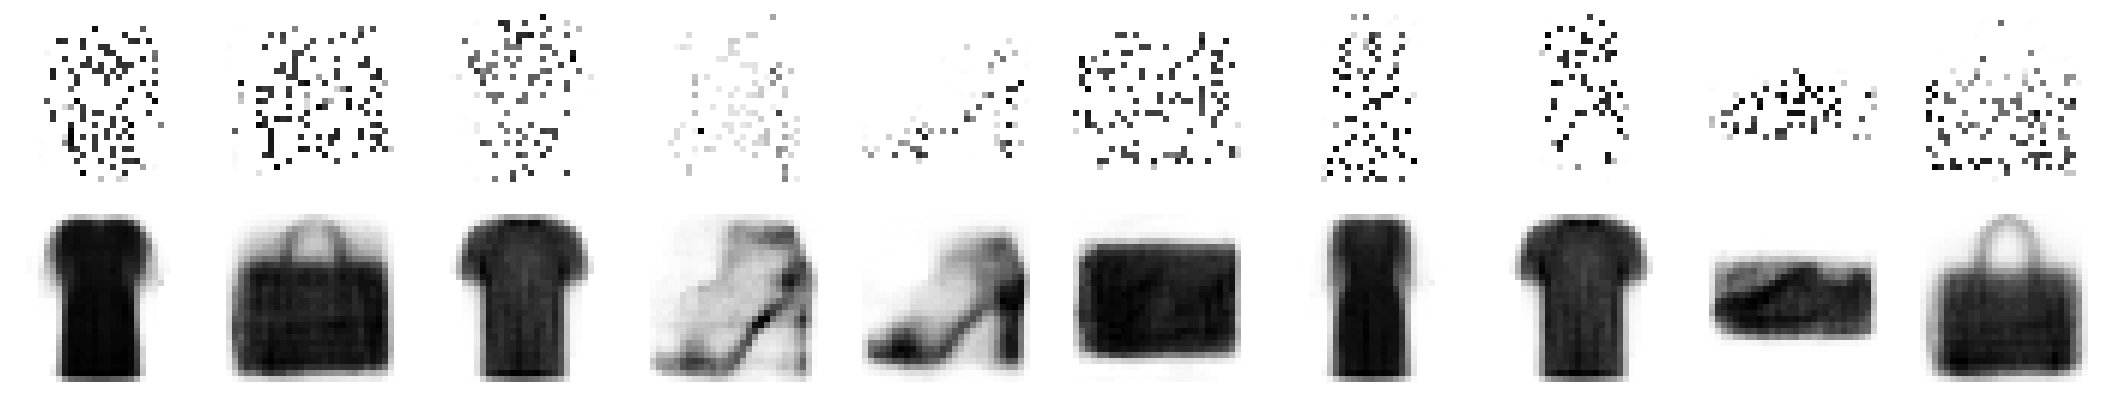

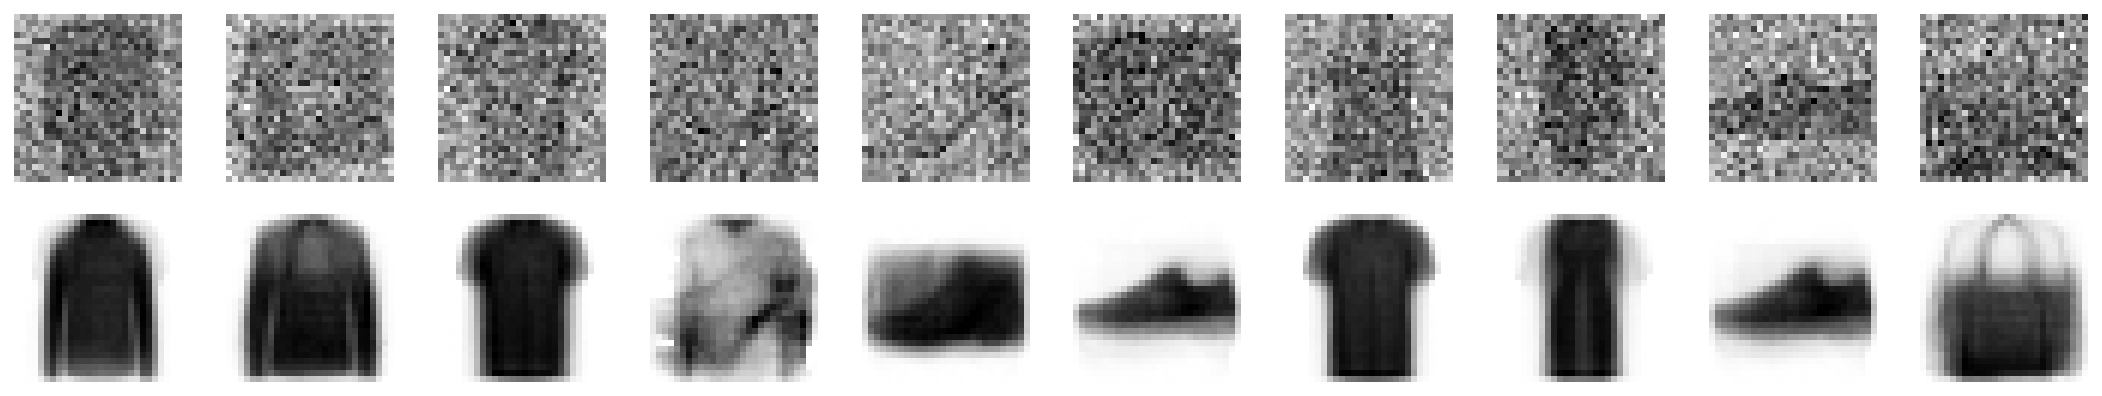

In [ ]:
#Type your code for Question #10
noise = Dropout(0.8)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

noise = GaussianNoise(0.5)
show_reconstructions(dropout_ae, noise(X_valid, training=True))

<font color=green> Describe what you see. 

They seem to do better than expected, though there are some errors in the reconstruction.
</font>

<font color=blue> **Question #11**: By now, you should have seen a few examples of "swapping" (e.g., the input image is a high heel, but for some reason, a purse or a boot emerges from the network).  These networks all have the structure $784\to 100\to 30 \to 2 \to 30 \to 100 \to 784 $.  Would you expect to see more or less swapping if we used a network with structure $784\to 100\to 30 \to 100 \to 784 $?  Explain your answer qualitatively (no need to actually implement the network).

<font color = green> Type your answer for Question #11 here 
If we have noise, having a code with dimension p such that p << m, where m is dimension of original data, would lead to less swapping. But if we don't have noise, a code with a dimension 1 > p would lead to less swapping.

The smaller we go with the code of our dimensionality, the more likely we are to have swapping, especially if the dimensionality of the code is less than the latent dimensionality of the input data. </font>